In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.datasets import fetch_datasets
from collections import Counter
import pathlib
import sys
sys.path.append(str(pathlib.Path.cwd().parent.parent))
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sv_synthsonic import synthsonic, load_data, pca_plot
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold

# general

In [32]:
home_folder = pathlib.Path.cwd().parent.parent
path = home_folder.joinpath(home_folder, 'CSV_results')
df_info = pd.read_csv(path.joinpath('dataset_info.csv'))

# oversampler results
df_xgb = pd.read_csv(path.joinpath('Experiment2', 'res_all_datasets.csv'), index_col=0)
df_kn = pd.read_csv(path.joinpath('Experiment3', 'res_all_datasets.csv'), index_col=0)
df_dt = pd.read_csv(path.joinpath('Experiment4', 'res_all_datasets.csv'), index_col=0)

# base results
xgb_base = pd.read_csv(path.joinpath('Experiment2', 'base_case_xgb.csv'))
kn_base = pd.read_csv(path.joinpath('Experiment3', 'base_case_kneighbors.csv'))
dt_base = pd.read_csv(path.joinpath('Experiment4', 'base_case_dectree.csv'))

df_all = pd.concat([df_xgb, df_kn, df_dt, xgb_base, kn_base, dt_base]).reset_index(drop=True)

import re 
# remove nans for NoOversampling results
df_all['proportion'] = df_all['proportion'].fillna(0)
df_all['runtime'] = df_all['runtime'].fillna(0)

df_all['classifier'] = df_all['classifier'].str.replace(re.escape(df_all['classifier'].unique()[0]),'XGBClassifier')
df_all['classifier'] = df_all['classifier'].str.replace(re.escape(df_all['classifier'].unique()[1]),'KneighborsClassifier')
df_all['classifier'] = df_all['classifier'].str.replace(re.escape(df_all['classifier'].unique()[2]),'DecisionTreeClassifier')

# split per classifier
df_all_xgb = df_all[df_all['classifier'] == df_all['classifier'].unique()[0]]
df_all_kn = df_all[df_all['classifier'] == df_all['classifier'].unique()[1]]
df_all_dt = df_all[df_all['classifier'] == df_all['classifier'].unique()[2]]

# Dataset info

In [58]:
df_info

,dataset,size,features,numerical_features,categorical_features,majority,minority,type,imbalance_ratio
0,ecoli,336.0,7.0,5.0,2.0,301.0,35.0,mixed,0.116279
1,optical_digits,5620.0,64.0,0.0,64.0,5066.0,554.0,categorical,0.109356
2,satimage,6435.0,36.0,36.0,0.0,5809.0,626.0,numerical,0.107764
3,pen_digits,10992.0,16.0,16.0,0.0,9937.0,1055.0,numerical,0.106169
4,abalone,4177.0,10.0,7.0,3.0,3786.0,391.0,mixed,0.103275
5,sick_euthyroid,3163.0,42.0,6.0,36.0,2870.0,293.0,mixed,0.102091
6,spectrometer,531.0,93.0,93.0,0.0,486.0,45.0,numerical,0.092593
7,car_eval_34,1728.0,21.0,0.0,21.0,1594.0,134.0,categorical,0.084065
8,isolet,7797.0,617.0,610.0,7.0,7197.0,600.0,mixed,0.083368
9,us_crime,1994.0,100.0,99.0,1.0,1844.0,150.0,mixed,0.081345


In [62]:
list(df_info[df_info['type'] != 'categorical']['dataset'])

['ecoli',
 'satimage',
 'pen_digits',
 'abalone',
 'sick_euthyroid',
 'spectrometer',
 'isolet',
 'us_crime',
 'yeast_ml8',
 'scene',
 'libras_move',
 'thyroid_sick',
 'coil_2000',
 'arrhythmia',
 'oil',
 'wine_quality',
 'yeast_me2',
 'ozone_level',
 'mammography',
 'protein_homo',
 'abalone_19']

# Select best performance per dataset

In [34]:
def get_best(df, dataset, metric) :
    
    temp_df = df[df['dataset'] == dataset]
    
    return df.loc[temp_df.groupby('oversampler')[metric].idxmax()].sort_values(metric, ascending=False)

def select_best(df, metric) :
    
    temp = []
    
    for dataset in df['dataset'].unique() :
        temp.append(get_best(df, dataset, metric))
        
    res = pd.concat(temp)
    
    return res

df_all = select_best(df_all, 'f1_score')
df_all_xgb = select_best(df_all_xgb, 'f1_score')
df_all_kn = select_best(df_all_kn, 'f1_score')
df_all_dt = select_best(df_all_dt, 'f1_score')
df_all_best = pd.concat([df_all_xgb, df_all_kn, df_all_dt])

# Based on dataset type

In [5]:
categorical = df_info[df_info['type'] == 'categorical']['dataset']
numerical = df_info[df_info['type'] == 'numerical']['dataset']
mixed = df_info[df_info['type'] == 'mixed']['dataset']

df_categorical = df_all[df_all['dataset'].isin(categorical)]
df_numerical = df_all[df_all['dataset'].isin(numerical)]
df_mixed = df_all[df_all['dataset'].isin(mixed)]

In [6]:
df_categorical.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
RandomOverSampler,0.583333,0.009701,0.900775,0.877383,0.815048,0.822894,0.810841,0.750204
Borderline_SMOTE1,0.333333,1.159874,0.893362,0.869334,0.812295,0.836037,0.795124,0.745319
ADASYN,0.466667,0.570936,0.908141,0.900929,0.810968,0.817892,0.841253,0.742270
synthsonic,0.283333,46.084395,0.896837,0.872939,0.807556,0.815624,0.801527,0.731830
SVMSMOTE,0.533333,5.167192,0.897418,0.886009,0.806548,0.822484,0.812356,0.729506
polynom_fit_SMOTE,0.566667,0.016817,0.908551,0.903482,0.804972,0.804485,0.855188,0.743985
SMOTE,0.300000,0.033151,0.894461,0.864954,0.804022,0.826303,0.795249,0.731133
Random_SMOTE,0.616667,0.169950,0.895060,0.884059,0.803207,0.822924,0.810687,0.729732
NoOversampling,0.000000,0.000000,0.877622,0.841623,0.794732,0.863776,0.759226,0.722603


In [7]:
df_numerical.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
RandomOverSampler,0.72,0.011729,0.781489,0.732713,0.624294,0.690077,0.586691,0.502946
synthsonic,0.50,79.126756,0.792139,0.750171,0.622968,0.642813,0.609915,0.493436
SVMSMOTE,0.49,1.903292,0.798523,0.767320,0.622714,0.645592,0.656062,0.490556
Random_SMOTE,0.53,0.093910,0.796717,0.760465,0.621238,0.634015,0.622999,0.482551
SMOTE,0.49,0.016841,0.795416,0.754786,0.615622,0.620240,0.617124,0.474914
ADASYN,0.54,0.308130,0.794265,0.759860,0.607546,0.614071,0.662982,0.461561
Borderline_SMOTE1,0.56,0.258673,0.779476,0.743186,0.605492,0.652990,0.606254,0.476205
polynom_fit_SMOTE,0.62,0.040012,0.787179,0.731774,0.604119,0.637763,0.666007,0.472374
NoOversampling,0.00,0.000000,0.734854,0.640412,0.548185,0.720192,0.476096,0.433406


In [8]:
df_mixed.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
SMOTE,0.527273,0.018385,0.827751,0.798006,0.610917,0.555766,0.700977,0.467100
SMOTENC,0.436364,0.773011,0.814655,0.782900,0.608739,0.586589,0.662706,0.470429
Random_SMOTE,0.327273,0.032221,0.817499,0.777458,0.603204,0.579456,0.677026,0.462510
RandomOverSampler,0.700000,0.003559,0.802886,0.760061,0.601225,0.584729,0.642162,0.458357
ADASYN,0.481818,0.261221,0.829589,0.805799,0.601114,0.551282,0.704458,0.454918
polynom_fit_SMOTE,0.609091,0.007365,0.783456,0.729853,0.600892,0.690981,0.592867,0.467484
SVMSMOTE,0.545455,0.658936,0.816474,0.786133,0.600765,0.557214,0.666817,0.452399
Borderline_SMOTE1,0.454545,0.220980,0.805785,0.764186,0.599195,0.594274,0.648273,0.451808
synthsonic,0.500000,252.100692,0.799911,0.757858,0.588353,0.562832,0.641204,0.448447


# Small datasets (n < 1.000)

In [9]:
small_sets = df_info[df_info['size'] < 1000]['dataset']
small_sets_performance = df_all[df_all['dataset'].isin(small_sets)]

small_sets_performance.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
SMOTE,0.680000,0.001966,0.931466,0.929645,0.797118,0.729134,0.888810,0.655080
Random_SMOTE,0.480000,0.007261,0.919053,0.916094,0.795817,0.758525,0.858810,0.659256
synthsonic,0.780000,64.847673,0.903998,0.898286,0.790000,0.769167,0.826905,0.655962
SVMSMOTE,0.600000,0.007925,0.905794,0.902236,0.780417,0.740036,0.832857,0.632137
RandomOverSampler,0.660000,0.001048,0.886292,0.875283,0.779601,0.794872,0.788333,0.651397
polynom_fit_SMOTE,0.460000,0.000903,0.885277,0.874744,0.774745,0.773939,0.786667,0.630116
ADASYN,0.580000,0.217539,0.928931,0.927300,0.769852,0.683333,0.888810,0.616828
SMOTENC,0.733333,0.217847,0.901568,0.895374,0.768483,0.738503,0.821429,0.620790
Borderline_SMOTE1,0.400000,0.003837,0.857048,0.839595,0.742222,0.793333,0.728333,0.602923


# medium datasets (1.000 < n < 10.000)

In [10]:
med_sets = df_info[df_info['size'].between(1000,10000)]['dataset']
med_sets_performance = df_all[df_all['dataset'].isin(med_sets)]

med_sets_performance.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
RandomOverSampler,0.658824,0.002995,0.768756,0.709481,0.562614,0.577060,0.573013,0.444107
ADASYN,0.511765,0.250252,0.783957,0.748350,0.557329,0.546981,0.639965,0.429662
SMOTE,0.494118,0.015503,0.777824,0.726918,0.557020,0.541323,0.594374,0.428967
Borderline_SMOTE1,0.482353,0.162840,0.774027,0.724264,0.556941,0.561940,0.597810,0.431500
SVMSMOTE,0.529412,0.490410,0.779016,0.739803,0.556291,0.548186,0.613912,0.428702
Random_SMOTE,0.464706,0.044929,0.773411,0.724862,0.553425,0.555578,0.591739,0.425756
synthsonic,0.447059,188.370227,0.766112,0.709504,0.550822,0.547936,0.570442,0.429656
SMOTENC,0.325000,0.981197,0.782062,0.740723,0.548835,0.529622,0.603185,0.414044
polynom_fit_SMOTE,0.635294,0.006538,0.762138,0.698143,0.546651,0.611415,0.603168,0.433123


# large datasets (n > 10.000)

In [11]:
big_sets = df_info[df_info['size'] > 10000]['dataset']
big_sets_performance = df_all[df_all['dataset'].isin(big_sets)]
big_sets_performance.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
Borderline_SMOTE1,0.48,1.837858,0.914976,0.908689,0.868144,0.912701,0.831970,0.770746
SVMSMOTE,0.42,9.781557,0.915744,0.909776,0.863163,0.900165,0.833789,0.762074
polynom_fit_SMOTE,0.64,0.093278,0.911675,0.904973,0.862806,0.908318,0.825109,0.763260
RandomOverSampler,0.78,0.031698,0.910194,0.902903,0.856850,0.897156,0.822571,0.753160
Random_SMOTE,0.46,0.302626,0.917355,0.911583,0.855911,0.882852,0.837557,0.751477
SMOTE,0.14,0.059234,0.909168,0.901964,0.849103,0.885099,0.821015,0.741238
synthsonic,0.14,62.869866,0.911506,0.904559,0.846587,0.870457,0.825903,0.734861
NoOversampling,0.00,0.000000,0.891298,0.879690,0.845952,0.930828,0.784014,0.743953
ADASYN,0.38,0.807671,0.909007,0.901904,0.845933,0.879362,0.820586,0.736984


# Features > samples

In [12]:
fs_sets = df_info[df_info['minority'] < df_info['features']]['dataset']
fs_performance = df_all[df_all['dataset'].isin(fs_sets)]
fs_performance.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
SMOTENC,0.800000,0.559094,0.919946,0.915724,0.787852,0.736748,0.857624,0.646477
synthsonic,0.550000,532.256523,0.869035,0.849044,0.733601,0.725235,0.756877,0.604309
SMOTE,0.683333,0.027102,0.878639,0.858063,0.731694,0.704339,0.777465,0.595875
Random_SMOTE,0.550000,0.042133,0.872203,0.850854,0.728527,0.720589,0.762987,0.595876
SVMSMOTE,0.633333,0.997073,0.866422,0.844832,0.718986,0.701804,0.752303,0.577855
ADASYN,0.600000,0.285476,0.875829,0.855054,0.710347,0.675298,0.774940,0.564140
RandomOverSampler,0.683333,0.004976,0.841592,0.806686,0.708902,0.765385,0.695288,0.589461
polynom_fit_SMOTE,0.550000,0.009062,0.845135,0.814553,0.708421,0.744390,0.705117,0.568704
Borderline_SMOTE1,0.533333,0.380977,0.822506,0.797372,0.671996,0.708903,0.668973,0.530109


# no. features

In [25]:
low_feats = df_info[df_info['features'] <= 10]['dataset']
low_feats_performance = df_all[df_all['dataset'].isin(low_feats)]
low_feats_performance.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
Borderline_SMOTE1,0.48,0.013294,0.771458,0.714651,0.536262,0.572674,0.582614,0.376075
RandomOverSampler,0.52,0.001297,0.750447,0.689646,0.511227,0.514240,0.543718,0.345368
SVMSMOTE,0.26,0.035136,0.778570,0.742483,0.510576,0.463734,0.594172,0.346508
polynom_fit_SMOTE,0.62,0.003387,0.718656,0.640408,0.505263,0.712398,0.460749,0.356365
Random_SMOTE,0.42,0.062886,0.774646,0.721253,0.498137,0.476528,0.607420,0.333737
ADASYN,0.60,0.224434,0.793885,0.774862,0.496888,0.437489,0.650108,0.321227
SMOTE,0.54,0.004662,0.778014,0.739014,0.496255,0.431467,0.617326,0.322378
synthsonic,0.62,2.976018,0.743347,0.682788,0.483526,0.466910,0.536855,0.320985
SMOTENC,0.25,0.043537,0.748034,0.709998,0.450212,0.415188,0.549229,0.298654


In [26]:
med_feats = df_info[df_info['features'].between(11,100)]['dataset']
med_feats_performance = df_all[df_all['dataset'].isin(med_feats)]
med_feats_performance.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
RandomOverSampler,0.782353,0.007803,0.849144,0.819364,0.726571,0.747114,0.713880,0.621297
SMOTE,0.441176,0.012552,0.860392,0.832558,0.724290,0.715504,0.738516,0.610475
SVMSMOTE,0.576471,1.205947,0.856672,0.833065,0.720545,0.723895,0.734003,0.606441
synthsonic,0.447059,26.391442,0.849924,0.819843,0.720170,0.728224,0.717170,0.613991
Random_SMOTE,0.411765,0.067790,0.854812,0.830980,0.719968,0.721971,0.730314,0.606865
ADASYN,0.488235,0.276580,0.859641,0.836766,0.714727,0.702697,0.743326,0.598582
polynom_fit_SMOTE,0.529412,0.025212,0.851994,0.823337,0.704964,0.703343,0.731943,0.597653
Borderline_SMOTE1,0.429412,0.168743,0.839422,0.804887,0.704127,0.729327,0.695851,0.595898
NoOversampling,0.000000,0.000000,0.809295,0.758364,0.674344,0.758586,0.629432,0.565254


In [27]:
lar_feats = df_info[df_info['features'] > 100]['dataset']
lar_feats_performance = df_all[df_all['dataset'].isin(lar_feats)]
lar_feats_performance.groupby('oversampler').mean().sort_values('f1_score', ascending=False)

,proportion,runtime,balanced_accuracy,geometric_mean,f1_score,precision,recall,avg_precision (AUPRC)
oversampler,,,,,,,,
SMOTENC,0.75,0.798925,0.957260,0.956036,0.859197,0.811005,0.929293,0.753180
polynom_fit_SMOTE,0.84,0.027301,0.772786,0.713650,0.594026,0.657301,0.713193,0.477611
Random_SMOTE,0.70,0.169272,0.784996,0.745624,0.587347,0.599115,0.617792,0.461224
ADASYN,0.44,0.711262,0.786728,0.753727,0.583744,0.595774,0.707858,0.458258
SMOTE,0.46,0.066568,0.781889,0.733418,0.581246,0.590548,0.602414,0.456812
synthsonic,0.30,675.469388,0.787198,0.744903,0.577277,0.559736,0.617077,0.443097
SVMSMOTE,0.60,7.321520,0.778938,0.752437,0.574541,0.579057,0.664167,0.443389
Borderline_SMOTE1,0.58,1.808331,0.778219,0.759515,0.573672,0.564244,0.644349,0.438641
RandomOverSampler,0.50,0.015102,0.772720,0.714937,0.567773,0.599604,0.588238,0.456744


# first placers

In [13]:
first_places = df_all_best.loc[df_all_best.groupby(['dataset','classifier'])['f1_score'].idxmax()]

first_places['oversampler'].value_counts().to_frame('First places')

,First places
Borderline_SMOTE1,15
RandomOverSampler,12
ADASYN,11
SVMSMOTE,10
NoOversampling,7
synthsonic,7
SMOTE,6
Random_SMOTE,6
polynom_fit_SMOTE,5
SMOTENC,2


# synthsonic performance (vs base clf)

In [14]:
all_best = df_all_best[df_all_best['oversampler'].isin(['synthsonic','NoOversampling'])]
all_best.groupby(['classifier','oversampler']).mean()

proportion     runtime  \
classifier             oversampler                              
DecisionTreeClassifier NoOversampling    0.000000    0.000000   
                       synthsonic        0.422222  141.016048   
KneighborsClassifier   NoOversampling    0.000000    0.000000   
                       synthsonic        0.457692  138.770416   
XGBClassifier          NoOversampling    0.000000    0.000000   
                       synthsonic        0.544444  141.606231   

                                       balanced_accuracy  geometric_mean  \
classifier             oversampler                                         
DecisionTreeClassifier NoOversampling           0.744794        0.664565   
                       synthsonic               0.792719        0.746443   
KneighborsClassifier   NoOversampling           0.675334        0.498992   
                       synthsonic               0.773334        0.711979   
XGBClassifier          NoOversampling           0.767019        0.672532   
                       synthsonic               0.806183        0.740724   

                                       f1_score  precision    recall  \
classifier             oversampler                                     
DecisionTreeClassifier NoOversampling  0.511876   0.512108  0.520369   
                       synthsonic      0.552141   0.504301  0.631126   
KneighborsClassifier   NoOversampling  0.417141   0.602564  0.358531   
                       synthsonic      0.507812   0.465400  0.600719   
XGBClassifier          NoOversampling  0.591347   0.692221  0.542905   
                       synthsonic      0.634891   0.656225  0.627361   

                                       avg_precision (AUPRC)  
classifier             oversampler                            
DecisionTreeClassifier NoOversampling               0.379011  
                       synthsonic                   0.410126  
KneighborsClassifier   NoOversampling               0.342010  
                       synthsonic                   0.387231  
XGBClassifier          NoOversampling               0.487925  
                       synthsonic                   0.522047

In [54]:
synthsonic_best = df_all_xgb[df_all_xgb['oversampler'] == 'synthsonic']
top10 = synthsonic_best.sort_values('f1_score', ascending=False)['dataset'].head(10)
df_info[df_info['dataset'].isin(list(top10))]

## Plots of precision recall curve

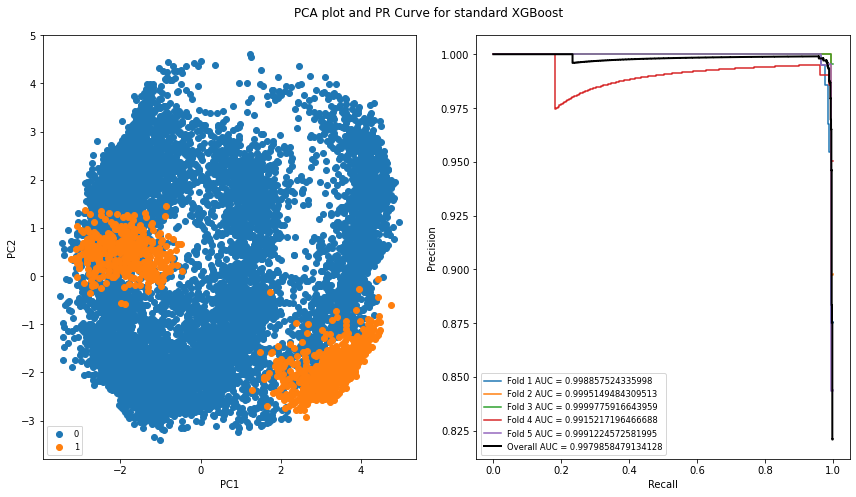

In [15]:
# Data and PCA plot
X,y,title = load_data('pen_digits')
x = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
counter = Counter(y)

# make plots
f, axes = plt.subplots(1, 2, figsize=(12, 7))
f.suptitle("PCA plot and PR Curve for standard XGBoost")
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

for label, _ in counter.items() :
    rowix = np.where(y == label)[0]
    axes[0].scatter(principalComponents[rowix, 0], principalComponents[rowix, 1], label=str(label))

axes[0].legend(loc='lower left', fontsize='small')

# do kfold cross val and plot the PR curves
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
clf = XGBClassifier(verbosity=0, use_label_encoder=False)

y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(k_fold.split(X,y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
    clf.fit(X_train, y_train)
    probas = clf.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(y_test, probas[:,1])
    lab = f"Fold {i} AUC = {auc(recall, precision)}"
    axes[1].step(recall, precision, label=lab)
    y_real.append(y_test)
    y_proba.append(probas[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = f"Overall AUC = {auc(recall, precision)}"
axes[1].step(recall, precision, label=lab, lw=2, color='black')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left', fontsize='small')

f.tight_layout()

2021-07-21 11:55:22,543:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'distinct_threshold': 20, 'random_state': 5, 'do_PCA': True}")
2021-07-21 11:55:22,543:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'distinct_threshold': 20, 'random_state': 5, 'do_PCA': True}")
Building tree: 100%|██████████| 105/105.0 [00:00<00:00, 673.50it/s]
Generating for node: 3: 100%|██████████| 16/16 [00:01<00:00, 12.64it/s] 
2021-07-21 11:55:36,409:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'distinct_threshold': 20, 'random_state': 5, 'do_PCA': True}")
2021-07-21 11:55:36,409:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'distinct_threshold': 20, 'random_state': 5, 'do_PCA': True}")
Building tree: 100%|██████████| 105/105.0 [00:00<00:00, 869.96it/s]
Generating for node: 3: 100%|██████████| 16/16 [00:01<00:00, 13.47it/s] 
2021-07-21 11:55:48,992:INFO:synthsonic: Running sampling via ('synthsonic

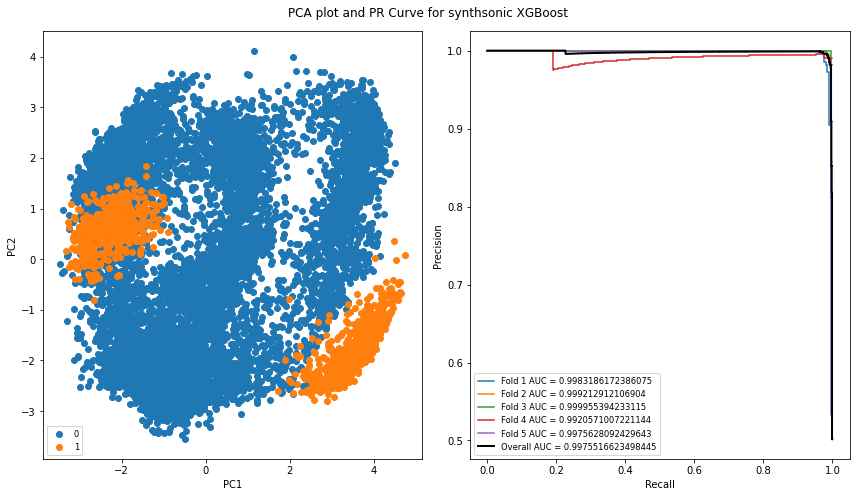

In [16]:
# Data and PCA plot
X,y,title = load_data('pen_digits')

oversampler = synthsonic(random_state=5, distinct_threshold=20, proportion=0.1)

X_g, _ = oversampler.sample(X,y)

x = StandardScaler().fit_transform(X_g)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


counter = Counter(y)

# make plots
f, axes = plt.subplots(1, 2, figsize=(12, 7))

f.suptitle("PCA plot and PR Curve for synthsonic XGBoost")

axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')


for label, _ in counter.items() :
    rowix = np.where(y == label)[0]
    axes[0].scatter(principalComponents[rowix, 0], principalComponents[rowix, 1], label=str(label))

axes[0].legend(loc='lower left', fontsize='small')


# do kfold cross val and plot the PR curves
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
clf = XGBClassifier(verbosity=0, use_label_encoder=False)

y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(k_fold.split(X,y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    # generate samples
    X_train, y_train = oversampler.sample(X_train, y_train)
    
    clf.fit(X_train, y_train)
    probas = clf.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(y_test, probas[:,1])
    lab = f"Fold {i} AUC = {auc(recall, precision)}"
    axes[1].step(recall, precision, label=lab)
    y_real.append(y_test)
    y_proba.append(probas[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = f"Overall AUC = {auc(recall, precision)}"
axes[1].step(recall, precision, label=lab, lw=2, color='black')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left', fontsize='small')

f.tight_layout()